# Introduction
***
Cet outil permet de concevoir un hacheur survolteur (boost converter) en visualisant l'efficacité selon les caractéristiques des composantes choisies. La topologie étudiée est représentée par la schématique suivante:

![dcdc](https://github.com/guimauve007/MPPT-builder/blob/main/assets/dcdc_boost.png?raw=1)

En fonctionnement continu, on observe le comportement suivant:

![traces](https://github.com/guimauve007/MPPT-builder/blob/main/assets/IL1_VGS.png?raw=1)



# Caractéristiques des composantes
***
Ici, on peut entrer les caractéristiques des composantes choisies pour le survolteur:

In [ ]:
# Inductance (L1)
L = 254*10**-6 # Valeur de l'inductance (en Henry)
RL = 80*10**-3 # Résistance de la bobine (en Ohms)


In [ ]:
# Switching FET (Q1)
RDS_SW = 10*10**-3 # Résistance entre le drain et la source (en Ohms)
CDS_SW = 2500*10**-12 # Capacité entre le drain et la source (en Farads)
T_SW = 10*10**-9 # Temps de transition on-off moyen (en secondes)

In [ ]:
# Rectifier FET (Q2)
RDS_RECT = 10*10**-3 # Résistance entre le drain et la source (en Ohms)

# Équations
***
La section suivante présente les différentes relations que l'on peut retrouver dans la topologie présentée plus haut.

## Nomenclature
---
Les variables utilisées dans les équations sont définies ci-dessous:
<br><br>

$D$ = Duty Cycle (\%)

$\Delta i$ = Variation de courant dans l'inductance (demi hauteur) (A)

$I_{MPP}$ = Courant moyen dans l'inductance (A)

$f$ = Fréquence de commutation (Hz)

$T$ = Période (Secondes)

$L$ = Inductance (H)

$T_{on}$ = Temps $ON$ de $Q1$ (Secondes)

$T_{off}$ = Temps $OFF$ de $Q1$ (Secondes)

$T_{SW(on)}$ = Temps de montée de $Q1$ (Secondes)

$T_{SW(off)}$ = Temps de descente de $Q1$ (Secondes)

$T_{SW}$ = Temps moyen de commutation de $Q1$ (Secondes)







## Variation de courant
---
Sachant que la tension aux bornes d'une inductance est directement proportionnelle à la dérivée du courant qui y circule, on peut établir la corrélation suivante, où $\Delta i$ correspond à la variation de courant (demi hauteur):

$$ V_{in}=L\cdot \frac{(2\cdot di)}{dt}= L\cdot \frac{(2\cdot \Delta i)}{T_{on}}$$

$$⇒ Δi=\frac{V_{in}}{L\cdot 2}\cdot T_{on}$$

$$⇒ \Delta i=\frac{V_{in}}{L\cdot 2}\cdot \frac{D}{f} \tag{1}$$


In [ ]:
def delta_i(vin, d, f, l):
    return (vin*d)/(l*2*f)

## Fréquence de commutation
---
À partir de l'équation présentée ci-haut, on peut retrouver la fréquence de commutation selon la variation de courant:

$$\Delta i=\frac{V_{in}}{L\cdot 2}\cdot \frac{D}{f}$$

$$⇒ f=\frac{V_{in}}{L\cdot 2}\cdot \frac{D}{\Delta i} \tag{2}$$


In [ ]:
def frequency(vin, d, di, l):
  return (vin*d)/(l*2*di)

## Rapport cyclique
---

En prenant la même équation présentée plus haut, soit la relation entre la dérivée du courant et la tension aux bornes de l'inductance, on peut isoler $\Delta t$ afin de déduire le ratio entre $T_{on}$ et la période $(T)$ pour trouver le rapport cyclique $(D)$:

$$V_{in}=L\cdot \frac{(2\cdot \Delta i)}{T_{on}}$$

$$⇒T_{on}=\frac{L\cdot (2\cdot \Delta i)}{V_{in}}$$

Même principe pour $T_{off}$:

$$(V_{out}-V_{in})=L\cdot \frac{(2\cdot \Delta i)}{T_{off}}$$

$$⇒T_{off}=\frac{L\cdot (2\cdot \Delta i)}{(V_{out}-V_{in})}$$

On peut maintenant résoudre pour $D$:

$$D=\frac{T_{on}}{T_{on}+T_{off}}$$

$$⇒ D=1-\frac{V_{in}}{V_{out}} \tag{3}$$



In [ ]:
def duty_cycle(vin, vout):
    return 1-(vin/vout)

## Pertes de rectification (Q2)
---
Au lieu d'utiliser une simple diode de type Schottky en sortie, on utilise un Mosfet (Q2) avec une faible résistance en conduction. La perte induite dans cette composante est calculée comme suit:

$$P_{loss}=\frac{\int_{0}^{T_{off}} R_{DS} \cdot I_{R}^2 \,dt}{T}$$

On retrouve au numérateur l'intégrale de la puissance instantanée qui donne l'énergie totale dissipée dans le Mosfet en conduction, qu'on divise ensuite par la période pour obtenir la puissance moyenne pour un cycle complet. On peut substituer $I_{R}$ par:

$$I_{R}=I_{MPP}+\Delta i-\frac{2\Delta i}{T_{off}} \cdot t$$

Soit le courant instantané circulant dans le Mosfet pour $t\in[0,T_{off}]$.

Où $$ T_{off}=(1-D) \cdot T$$

Par substitution dans la première équation et par résolution de l'intégrale, on obtient:

$$⇒ P_{loss}=\frac{-(D-1) \cdot (\Delta i^2+3 \cdot I_{MPP}^2) \cdot R_{DS}}{3} \tag{4}$$

In [ ]:
def ploss_q2(d, di, impp, rds_rect):
    return -((d-1)*(di**2+3*impp**2)*rds_rect)/3

## Pertes de commutation (Q1)
La perte de commutation est causée par le temps de commutation du mosfet principal (Q1). Cette perte est illustrée dans la figure suivante par le chevauchement entre le courant de drain ($I_{Drain}$) et la tension entre le drain et la source ($V_{DS}$ (ou $V_{out}$)) lors de la commutation:

![switching loss](https://github.com/guimauve007/MPPT-builder/blob/main/assets/switching_loss.png?raw=1)

On considérera le pire des scénarios où il y a un chevauchement <u>complet</u> des deux courbes. De plus, on prendra les hypothèses suivantes:

$$T_{SW(off)}=T1=T2$$

$$T_{SW(on)}=T3=T4$$

<br>

### Pertes de transition $(ON→OFF)$:

$$
E_{SW(off)}=\int_{0}^{T_1}\left(\frac{V_{out}}{T_1}t\left(\frac{2\cdot \Delta i}{T_{on}}t+I_{mpp}+\Delta i-\frac{2\cdot \Delta i}{T_{on}}T_1\right)\right)dt+\\
\int_{0}^{T_2}\left(V_{out}(I_{mpp}+\Delta i-\frac{I_{mpp}+\Delta i}{T_2}t)\right)dt\bigg|_{T_1=T_2=T_{SW(off)}}
$$

<br>

En remplacant $T_{on}$ par $\frac{D}{f}$, on obtient:

<br>

$$\Rightarrow E_{SW(off)}=\frac{(3\cdot D\cdot (\Delta i+i_{mpp})-f\cdot \Delta i \cdot T_{SW(off)})\cdot T_{SW(off)}\cdot V_{out}}{3\cdot D}\tag{5}$$

<br>

### Pertes de transition $(OFF→ON)$:

$$
E_{SW(on)} = \int_0^{T_3} V_{out} \left(\frac{I_{mpp} - \Delta i}{T_3}\right) t\, dt + \\
\int_0^{T_4} \left(V_{out} - \frac{V_{out}}{T_4} t\right) \left(I_{mpp} - \Delta i + \frac{2\cdot \Delta i}{T_{on}} t\right) \, dt \bigg|_{T_3 = T_4 = T_{SW(on)}}
$$

$$
⇒E_{SW(on)}=\frac{-(3\cdot D(\Delta i - I_{mpp}) - f\cdot \Delta i\cdot T_{SW(on)}) T_{SW(on)} V_{out}}{3\cdot D}
\tag{6}
$$

<br>

En additionnant les pertes trouvées en $(4)$ et $(5)$ et en divisant par la période $T$ (ou en multipliant par la fréquence $f$), on obtient la puissance moyenne, dissipée par commutation:

$$
P_{loss}=(E_{SW(off)}+E_{SW(on)})\cdot f
$$

$$
⇒P_{loss}=\frac{f\cdot V_{out}}{3\cdot D}\left(3\cdot D\cdot (\Delta i(T_{SW(off)}-T_{SW(on)})+I_{mpp}(T_{SW(off)}+T_{SW(on)}))-f\cdot \Delta i((T_{SW(off)})^2-(T_{SW(on)})^2)\right)\tag{7}
$$
<br>

...un peu pénible. Heureusement, on peut simplifier l'équation en posant $\ T_{SW}=T_{SW(off)}=T_{SW(on)}$. L'équation devient:

<br>

$$
P_{loss}=2 \cdot T_{SW} \cdot I_{MPP} \cdot V_{out} \cdot f \tag{8}
$$



In [ ]:
def ploss_q1_sw(impp, f, t_sw, vout):
    return 2*t_sw*impp*vout*f

## Pertes DC (Q1)
La puissance dissipée dans le mosfet Q1 en conduction est représentée par l'équation qui suit:

$$ P_{loss}=\frac{\int_{0}^{T_{on}} R_{DS} \cdot I^2\,dt}{T}$$

Où
$$ I=I_{MPP}-\Delta i+2 \cdot \Delta i \cdot \frac{t}{T_{on}} $$

En résolvant la première équation, on obtient:

$$P_{loss}=D \cdot R_{DS} \cdot (I_{MPP}^2+\frac{\Delta i^2}{3}) \tag{9}$$



In [ ]:
def ploss_q1_rds(d, rds, impp, di):
  return d*rds*(impp**2+(di**2/3))

## Pertes DC de l'inductance (L1)
---
Pour calculer les pertes dans l'inductance $L1$, on trouve l'énergie totale dissipée pendant une période complète, et on divise par cette même période pour obtenir la puissance moyenne par cycle:

$$P_{loss}=\frac{\int_{0}^{T_{on}} R_L\cdot I_{L(on)}^2\ dt + \int_{0}^{T_{off}} R_L\cdot I_{L(off)}^2\ dt}{(T_{on}+T_{off})}$$

Où

$$I_{L(on)}=(I_{MPP}-\Delta i)+\frac{2\cdot \Delta i}{T_{on}}\cdot t$$

$$I_{L(off)}=(I_{MPP}+\Delta i)+\frac{2\cdot \Delta i}{T_{off}}\cdot t$$

Par résolution de la première équation, on obtient:

$$P_{loss}=R_L \cdot [(I_{MPP})^2+\frac{\Delta I^2}{3}] \tag{10}$$


In [ ]:
def ploss_l1(impp, delta_i, rl):
    return rl*((impp**2)+((delta_i**2)/3))

## Pertes de commutation ($C_{DS}$)
---

Pertes de commutation liées au condensateur parallèle $C_{DS}$ de $Q1$. Cette perte est causée par la décharge de celui-ci lorsque le Mosfet commute. On supposera que ce condensateur est pleinement chargé lors de la commutation:

$$P_{loss}=\frac{1}{2} \cdot C_{DS} \cdot (V_{out})^2 \cdot f \tag{11}$$

In [ ]:
def ploss_q1_cds(f, vout, cds_sw):
    return (1/2)*cds_sw*(vout**2)*f

# Pertes totales
---

In [ ]:
def ploss_tot(f, i_mpp, vin, vout):

  # caractéristiques du hacheur
  l = L
  rl = RL
  rds_sw = RDS_SW
  cds_sw = CDS_SW
  t_sw = T_SW
  rds_rect = RDS_RECT

  # variables de fonctionnement
  d = duty_cycle(vin, vout)
  di = delta_i(vin, d, f, l)

  # pertes totales
  return ploss_q2(d, di, i_mpp, rds_rect) + ploss_q1_sw(i_mpp, f, t_sw, vout) + ploss_q1_rds(d, rds_sw, i_mpp, di) + ploss_l1(i_mpp, di, rl) + ploss_q1_cds(f, vout, cds_sw)

In [ ]:
def efficiency(f, i_mpp, vin, vout):
  p_in = vin*i_mpp
  p_out = p_in - ploss_tot(f, i_mpp, vin, vout)

  return p_out/p_in

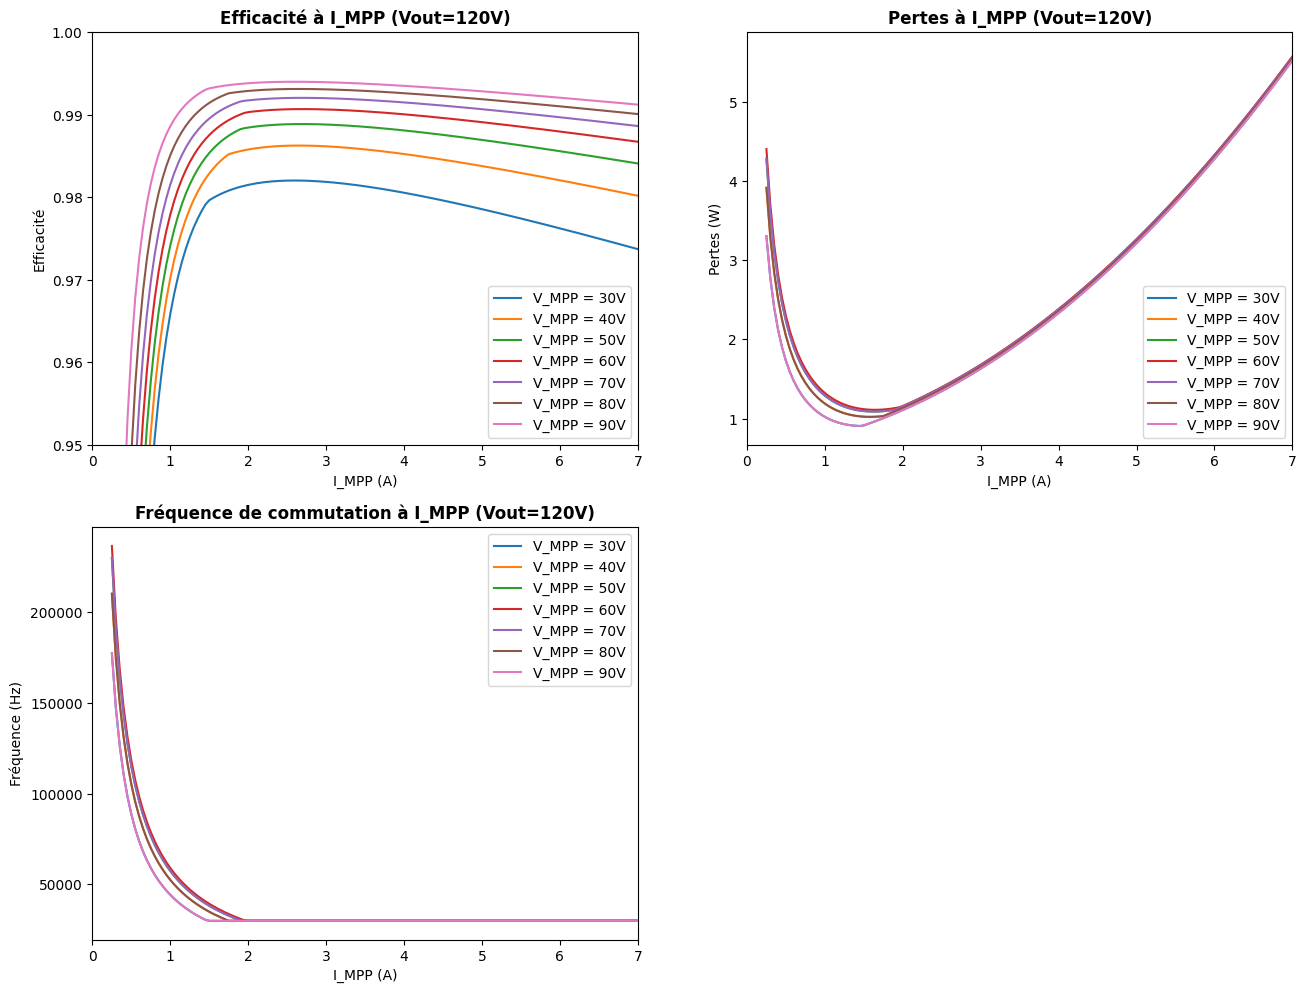

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

V_OUT = 120 # V
FIXED_FREQUENCY = 30000 # Hz
MAX_FREQUENCY = 300000 # Hz
MAX_I_MPP = 7 # A
MIN_V_MPP = 30 # V
MAX_V_MPP = 90 # V

v_mpp = np.arange(MIN_V_MPP, MAX_V_MPP + 1, 10)
i_mpp = np.arange(0.25, MAX_I_MPP + 0.1, 0.05)

eff = 0
power_loss = 0
critic_freq = 0
op_freq = 0

efficiency_list = []
frequency_list = []
loss_list = []

for v in v_mpp:
  for i in i_mpp:
    critic_freq = frequency(v, duty_cycle(v, V_OUT), i, L)

    if(critic_freq < FIXED_FREQUENCY):
      op_freq = FIXED_FREQUENCY
    else:
      op_freq = critic_freq

    if(op_freq > MAX_FREQUENCY): # On éteint le dcdc
      efficiency_list.append(None)
      frequency_list.append(None)
      loss_list.append(None)

    else:
      eff = efficiency(op_freq, i, v, V_OUT)
      efficiency_list.append(eff)
      frequency_list.append(op_freq)
      power_loss = v*i*(1-eff)
      loss_list.append(power_loss)


  # On remplit les données pour chaque v_mpp
  plt.subplot(2,2,1)
  plt.plot(i_mpp, efficiency_list, label="V_MPP = " + str(v) + "V")
  plt.subplot(2,2,3)
  plt.plot(i_mpp, frequency_list, label="V_MPP = " + str(v) + "V")
  plt.subplot(2,2,2)
  plt.plot(i_mpp, loss_list, label="V_MPP = " + str(v) + "V")
  loss_list.clear()
  efficiency_list.clear()
  frequency_list.clear()


plt.subplot(2,2,1)
plt.title("Efficacité à I_MPP (Vout="+str(V_OUT)+"V)", fontweight ="bold")
plt.xlabel("I_MPP (A)")
plt.ylabel("Efficacité")
plt.ylim(0.95, 1)
plt.xlim(0, MAX_I_MPP)
plt.legend()


plt.subplot(2,2,2)
plt.title("Pertes à I_MPP (Vout="+str(V_OUT)+"V)", fontweight ="bold")
plt.xlabel("I_MPP (A)")
plt.ylabel("Pertes (W)")
plt.xlim(0, MAX_I_MPP)
plt.legend()


plt.subplot(2,2,3)
plt.title("Fréquence de commutation à I_MPP (Vout="+str(V_OUT)+"V)", fontweight ="bold")
plt.xlabel("I_MPP (A)")
plt.ylabel("Fréquence (Hz)")
plt.xlim(0, MAX_I_MPP)
plt.legend()


plt.subplots_adjust(top=2, right=2)
plt.show()